The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
['fmf', 'greedy-adaptive-knn', 'greedy-adaptive-mf', 'greedy-adaptive-ppr-collab', 'greedy-adaptive-ppr-joint', 'greedy-adaptive-ppr-kg', 'greedy-adaptive-ppr-linear-learned', 'lrmf', 'melu'] [0.2048821548821549, 0.23283403656821375, 0.27034202787367345, 0.17320110386566082, 0.15933363167540382, 0.09157556578442654, 0.14513276222136984, 0.20642905851766613, 0.2614593189276734] [0.0, 0.024952689950214324, 0.028855101222352093, 0.028026602629055833, 0.0188866456208765

/home/anders/Code/cold-start-framework/.venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/anders/Code/cold-start-framework/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


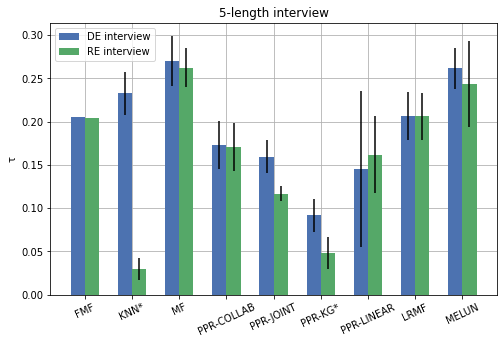

In [52]:
%load_ext autoreload
%autoreload 2

from requests import get
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, ttest_rel

plt.rcParams['axes.linewidth'] = 0.8
plt.style.use('seaborn-deep')
print(plt.style.available)
metric = 'tau'
cutoff = '3'
n_questions = 5
significance_level = 0.05
experiment = 'separation'
interviewer = 'AdaptiveGreedy'
sota = {'lrmf', 'fmf', 'melu'}

data = get(f'https://mindreader.tech/spectate/results/{experiment}/{metric}/{cutoff}').json()
data = {k: v for k, v in data.items() if not 'grid' in k}
metric = metric.replace('cov', 'div')  # Hack job :-)

#data = get(f'http://localhost:5000/spectate/results/equal/{metric}/{cutoff}').json()


def results_len(from_model):
    return sum([len(split) for split in [question for question in data[from_model]]])

def is_allowed(model):
    for allowed in sota:
        if allowed in model:
            return True
    
    if interviewer == 'FixedGreedy':
        return model.startswith('greedy') and 'adaptive' not in model
    elif interviewer == 'FixedPop':
        return model.startswith('pop')
    elif interviewer == 'AdaptiveGreedy':
        return model.startswith('greedy-adaptive')
    elif interviewer == 'DQN':
        return model.startswith('dqn-')
    elif interviewer == 'ddpg':
        return model.startswith('ddpg-')
    
    return False
    
models = sorted([key for key in data.keys() if key.endswith('-rec') and is_allowed(key)], reverse=False)
models = [model for model in models if len(data[model]) >= n_questions]

fig, ax = plt.subplots(figsize=(8, 5))
ind = np.arange(len(models))

width = 0.3

# add with rec
for idx, (label, to_replace) in enumerate([('DE interview', '-rec'), ('RE interview', '')]):
    x = [model.replace(to_replace, '') for model in models]
    y = [np.mean(data[model][n_questions - 1]) for model in x]
    y_std = [np.std(data[model][n_questions - 1]) for model in x]
    
    print(x, y, y_std)
    ax.bar(ind + idx * width, y, yerr=y_std, width=width, label=label, zorder=3)

def get_postfix(model):
    re_data = f'{model}-rec'
    if re_data not in data:
        return ''
    
    re = data[re_data][n_questions - 1]
    de = data[model][n_questions - 1]
    
    if len(re) == len(de) and ttest_rel(de, re)[1] <= significance_level:
        return '*'
    
    return ''

# get best

# add statistical significance
displays = [model.replace('-rec', '') for model in models]
displays = [model.replace('greedy-', '').replace('melu', 'melun').replace('adaptive-', '').replace('pop-', '').replace('-learned', '').upper() + get_postfix(model) for model in displays]
displays = [model.upper() for model in displays]

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(displays)
plt.xticks(rotation=25)

bottom, top = ax.yaxis.get_data_interval()

#plt.ylim([0.02, top * 1.05])

if metric == 'tau':
    plt.ylabel('τ')
else:
    plt.ylabel(f'{metric.upper()}@{cutoff}')
plt.title(f'{n_questions}-length interview')
plt.legend(loc='upper left')
plt.grid(True, zorder=0)
plt.savefig(f'output/{experiment}_{interviewer.lower()}_{metric}{cutoff}_re_vs_de.pdf', bbox_inches='tight')
plt.show()

In [53]:
def get_best(json_data, questions):
    de_models = [model.replace('-rec', '') for model in models]
    de_models = [model for model in de_models if model not in sota]
    
    return max(de_models, key=lambda key: np.mean(json_data[key][questions - 1]) if len(json_data[key]) >= n_questions else 0)

def compare_significance(model_a, model_b):
    data_a = data[model_a][n_questions - 1]
    data_b = data[model_b][n_questions - 1]
    
    print(f'{model_a}: {np.mean(data_a)}')
    print(f'{model_b}: {np.mean(data_b)}')

    t, p = ttest_rel(data_a, data_b)
    print(f'{model_a} vs. {model_b}: {p * 100:.4f}%{"*" if p <= significance_level else None}')

compare_significance('lrmf-rec', get_best(data, 5))
print()
compare_significance('melu-rec', get_best(data, 10))
print()
compare_significance('melu-rec', get_best(data, 10))
print()

lrmf-rec: 0.2062160635894813
greedy-adaptive-mf: 0.27034202787367345
lrmf-rec vs. greedy-adaptive-mf: 1.3649%*

melu-rec: 0.24319130119763033
greedy-adaptive-mf: 0.27034202787367345
melu-rec vs. greedy-adaptive-mf: 11.5005%None

melu-rec: 0.24319130119763033
greedy-adaptive-mf: 0.27034202787367345
melu-rec vs. greedy-adaptive-mf: 11.5005%None

